Computer vision - Face Recognition Challenge

Giảng viên hướng dẫn: PGS.TS Lê Đình Duy

Học viên: Hoàng Anh Minh - CH1801010

Tài liệu tham khảo: https://github.com/ageitgey/face_recognition



In [1]:
#CÀI ĐẶT THƯ VIỆN SỬ DỤNG PIP3: Thư viện sklearn,dlib, face_recognition
import sys
!{sys.executable} -m pip install dlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install face_recognition

  Using cached https://files.pythonhosted.org/packages/85/04/49633f490f726da6e454fddc8e938bbb5bfed2001681118d3814c219b723/scikit_learn-0.21.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/72/4c/5f81e7264b0a7a8bd570810f48cd346ba36faedbd2ba255c873ad556de76/scipy-1.3.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/87/2d/e4656149cbadd3a8a0369fcd1a9c7d61cc7b87b3903b85389c70c989a696/numpy-1.16.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/cd/c1/50a758e8247561e58cb87305b1e90b171b8c767b15b12a1734001f41d356/joblib-0.13.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3f/ed/ad9a28042f373d4633fc8b49109b623597d6f193d3bbbef7780a5ee8eef2/face_recognition-1.2.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/87/2d/e4656149cbadd3a8a0369fcd1a9c7d61cc7b87b3903b85389c70c989a696/numpy-1.16.4-cp36-cp36m-manylinux1_x86_64.whl

In [63]:
#IMPORT các thư viện cần thiết
import math
from sklearn import neighbors
import os
import os.path
import pickle
from PIL import Image, ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder
from matplotlib.pyplot import imshow
import numpy as np
from IPython.display import display
ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

In [66]:
def train(train_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):
    """
    hàm train k-nearest neighbors classifier cho face recognition.
    :param train_dir: chứa folder các mặt cần train, có định dạng:
        <train_dir>/
        ├── <person1>/
        │   ├── <somename1>.jpeg
        │   ├── <somename2>.jpeg
        │   ├── ...
        ├── <person2>/
        │   ├── <somename1>.jpeg
        │   └── <somename2>.jpeg
        └── ...
    :param model_save_path: (optional) đường dẫn save model, tiện cho lần sử dụng sau
    :param n_neighbors: (optional) số lượng neighbor cần để train, tự động chọn nếu k chọn
    :param knn_algo: (optional) thuật toán knn, default là 'ball_tree'
    :param verbose: True sẽ print ra lỗi nếu file trainning (các mặt k phù hợp)
    :return: return knn classifiers cho dataset đã train.
    """
    X = []
    y = []

    # lặp trong từng folder trainning
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue

        # Lặp qua ảnh mặt của từng người trong folder
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            #Hàm load ảnh
            image = face_recognition.load_image_file(img_path)
            #Ở đây vì db là mặt nên chúng ta k cần phải detect như trong code,
            #có thể dùng chính ảnh đó làm bounding box
            #face_bounding_boxes = face_recognition.face_locations(image)
            img_shape = image.shape
            face_bounding_boxes = [(0, img_shape[1]-1, img_shape[0]-1, 0)]
            if len(face_bounding_boxes) != 1:
                # Nếu số mặt khác 1, k có mặt hoặc quá nhiều mặt, bỏ qua.
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                print("{}".format(face_bounding_boxes[0]))
                # Thêm face encoding vào trainning data
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)

    # Tính số  neighbor dùng trong knn
    if n_neighbors is None:
        # Nếu k define, chúng ta sẽ lấy căn bậc hai của số lượng mặt trong trainning set
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # tạo và train knn classifier
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf


def predict(X_img_path, knn_clf=None, model_path=None, distance_threshold=0.5):
    """
    Nhận diện khuôn mặt sử dụng knn classifier
    :param X_img_path: ảnh cần nhận diện
    :param knn_clf: (optional) knn classifier object. nếu nếu k truyền vào, model_save_path phải được chọn.
    :param model_path: (optional) đường dẫn để chọn knn classifier. nếu k truyền vào, model_save_path phải là knn_clf.
    :param distance_threshold: (optional) threshold để nhận diện mặt người, nếu càng lớn thì khả năng nhận 
    nhầm unknown person càng cao.
    :return: list name và bounding box của ảnh cần nhận diện, có dạng: [(name, bounding box), ...].
        nếu mặt không biết, trả về 'unknown'.
    """
    # Check format file truyền vào
    if not os.path.isfile(X_img_path) or os.path.splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Invalid image path: {}".format(X_img_path))
    
    # Check object knn và model path
    if knn_clf is None and model_path is None:
        raise Exception("Must supply knn classifier either thourgh knn_clf or model_path")

    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load ảnh và tìm mặt, sử dụng thư viện face_regcognition
    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img)

    # Nếu không thấy mặt nào thì trả kq về ds rỗng.
    if len(X_face_locations) == 0:
        return []

    # Tìm ra face encodings cho các face đã detect được
    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

    # Sử dụng knn để tìm ra mặt nào hợp nhất
    closest_distances = knn_clf.kneighbors(faces_encodings)
    #Trả về list True nếu distance bé hơn và False nếu distance lớn hơn giá trị đã set
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

    # Dự đoán và trả về 'unknown' nếu kq có threshold bé hơn giá trị đã set
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]


def show_prediction_labels_on_image(img_path, predictions):
    """
    Show kết quả bằng vẽ mặt.
    :param img_path: đường dẫn file test
    :param predictions: kết qủa dự đoán
    :return:
    """
    # Load image và vẽ ảnh
    pil_image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(pil_image)
    # Vẽ hết tất cả các face đã được recognition
    for name, (top, right, bottom, left) in predictions:
        # vẽ bounding box 
        draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))
        # There's a bug in Pillow where it blows up with non-UTF-8 text
        # when using the default bitmap font
        name = name.encode("UTF-8")

        # Vẽ label với tên ở dưới bounding box
        text_width, text_height = draw.textsize(name)
        draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
        draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))

    # Remove the drawing library from memory as per the Pillow docs
    del draw

    # Sử dụng iPython để vẽ hình ở Jupiter Notebook
    #print(pil_image.show())
    display(pil_image)

In [47]:
# STEP 1: Train knn classifier
print("Training KNN classifier...")
classifier = train("../2.FaceDB", model_save_path="trained_knn_model.clf", n_neighbors=2,verbose=True)
print("Training complete!")



Training KNN classifier...
(0, 231, 282, 0)
(0, 138, 170, 0)
(0, 94, 113, 0)
(0, 200, 297, 0)
(0, 155, 153, 0)
(0, 122, 122, 0)
(0, 82, 82, 0)
(0, 145, 141, 0)
(0, 175, 151, 0)
(0, 130, 164, 0)
(0, 96, 124, 0)
(0, 65, 65, 0)
(0, 684, 684, 0)
(0, 705, 705, 0)
(0, 68, 68, 0)
(0, 179, 244, 0)
(0, 259, 279, 0)
(0, 313, 394, 0)
(0, 116, 146, 0)
(0, 98, 98, 0)
(0, 655, 856, 0)
(0, 63, 73, 0)
(0, 653, 775, 0)
(0, 273, 336, 0)
(0, 192, 237, 0)
(0, 182, 222, 0)
(0, 112, 135, 0)
(0, 120, 152, 0)
(0, 93, 119, 0)
(0, 162, 197, 0)
(0, 266, 322, 0)
(0, 288, 319, 0)
(0, 218, 263, 0)
(0, 95, 133, 0)
(0, 55, 61, 0)
(0, 101, 105, 0)
(0, 166, 216, 0)
(0, 69, 90, 0)
(0, 192, 220, 0)
(0, 190, 225, 0)
(0, 306, 365, 0)
(0, 113, 134, 0)
(0, 170, 212, 0)
(0, 138, 174, 0)
(0, 149, 180, 0)
(0, 107, 132, 0)
(0, 203, 249, 0)
(0, 181, 226, 0)
(0, 120, 145, 0)
(0, 88, 109, 0)
Training complete!


Looking for faces in 1.png
- Found TIENBDT at (641, 422)
- Found TULG at (525, 430)
- Found TULG at (597, 398)
- Found TULG at (449, 418)
- Found CUONGNT at (709, 460)
- Found TULG at (45, 412)
- Found TULG at (493, 382)
- Found TULG at (1033, 519)


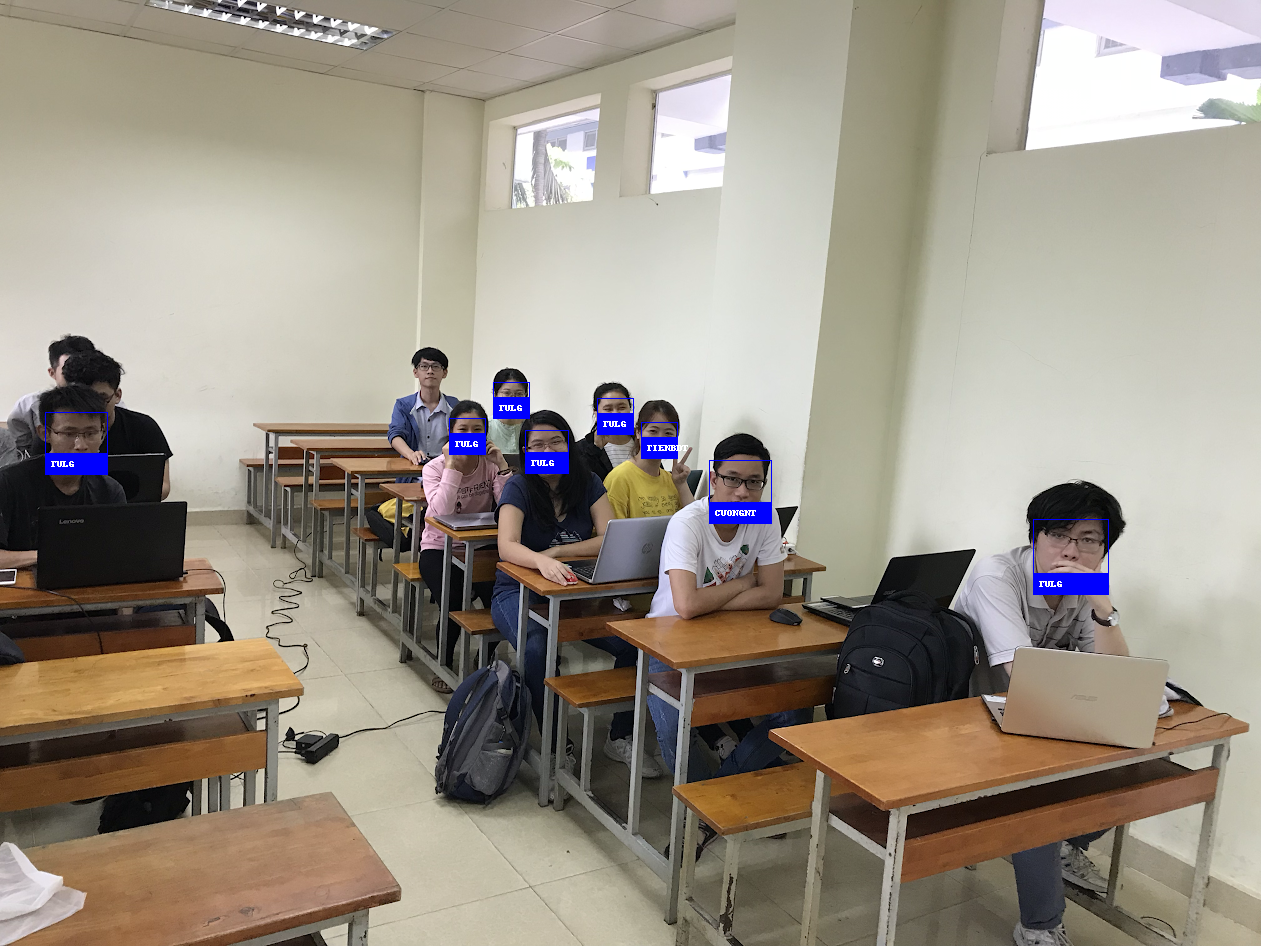

Looking for faces in 3.png
- Found MINHHA at (458, 286)
- Found HANTQ at (44, 510)
- Found VULQ at (749, 298)
- Found MYNH at (1085, 302)
- Found VULQ at (299, 310)
- Found QUANVM at (563, 377)
- Found HOAISD at (717, 349)
- Found TAIHPT at (1001, 504)
- Found QUANVM at (204, 308)
- Found unknown at (1159, 324)
- Found unknown at (516, 329)
- Found TULG at (589, 262)
- Found VULQ at (1189, 278)
- Found DUYETLV at (26, 320)
- Found unknown at (1045, 282)
- Found TIENBDT at (913, 262)


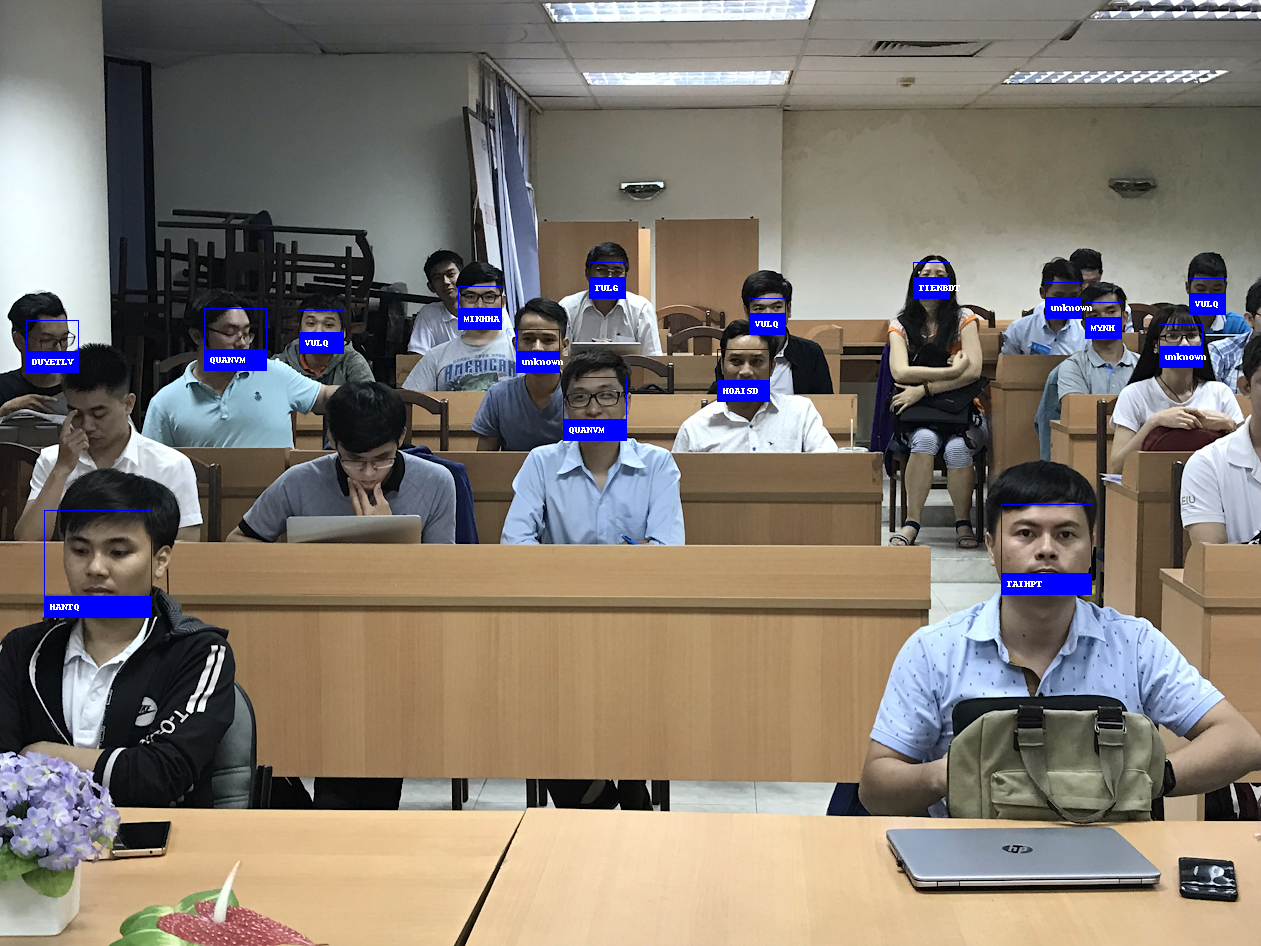

Looking for faces in 2.png
- Found TULG at (890, 314)
- Found NHANTH at (55, 362)
- Found LOCTH at (271, 324)
- Found TIENBDT at (793, 278)
- Found TULG at (349, 302)
- Found MYNH at (729, 290)


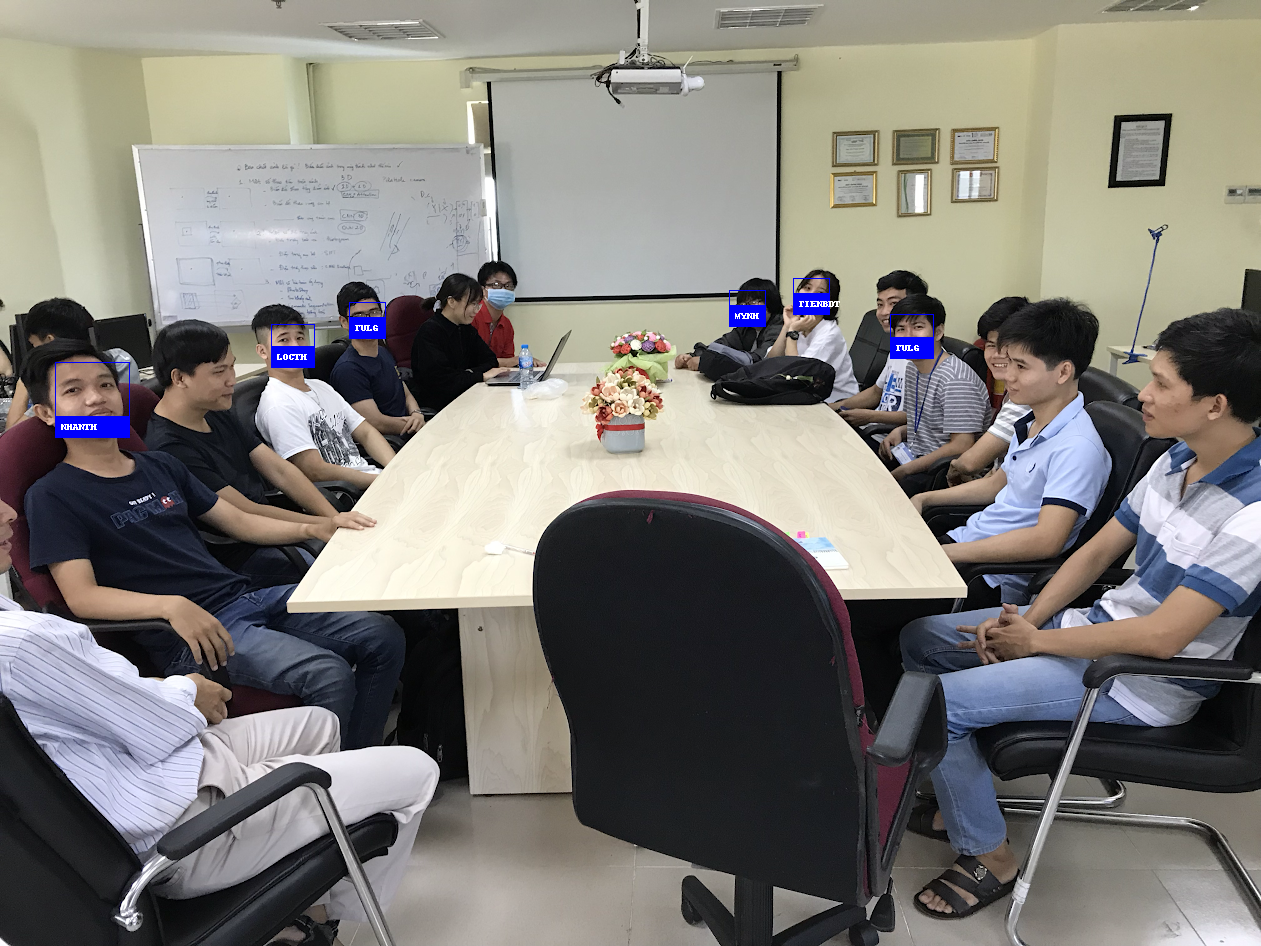

Looking for faces in 4.png
- Found VULQ at (509, 474)
- Found VULQ at (80, 294)
- Found ANHLT at (444, 387)
- Found HOAISD at (822, 435)
- Found VULQ at (801, 337)
- Found MINHHA at (312, 320)
- Found TULG at (563, 281)


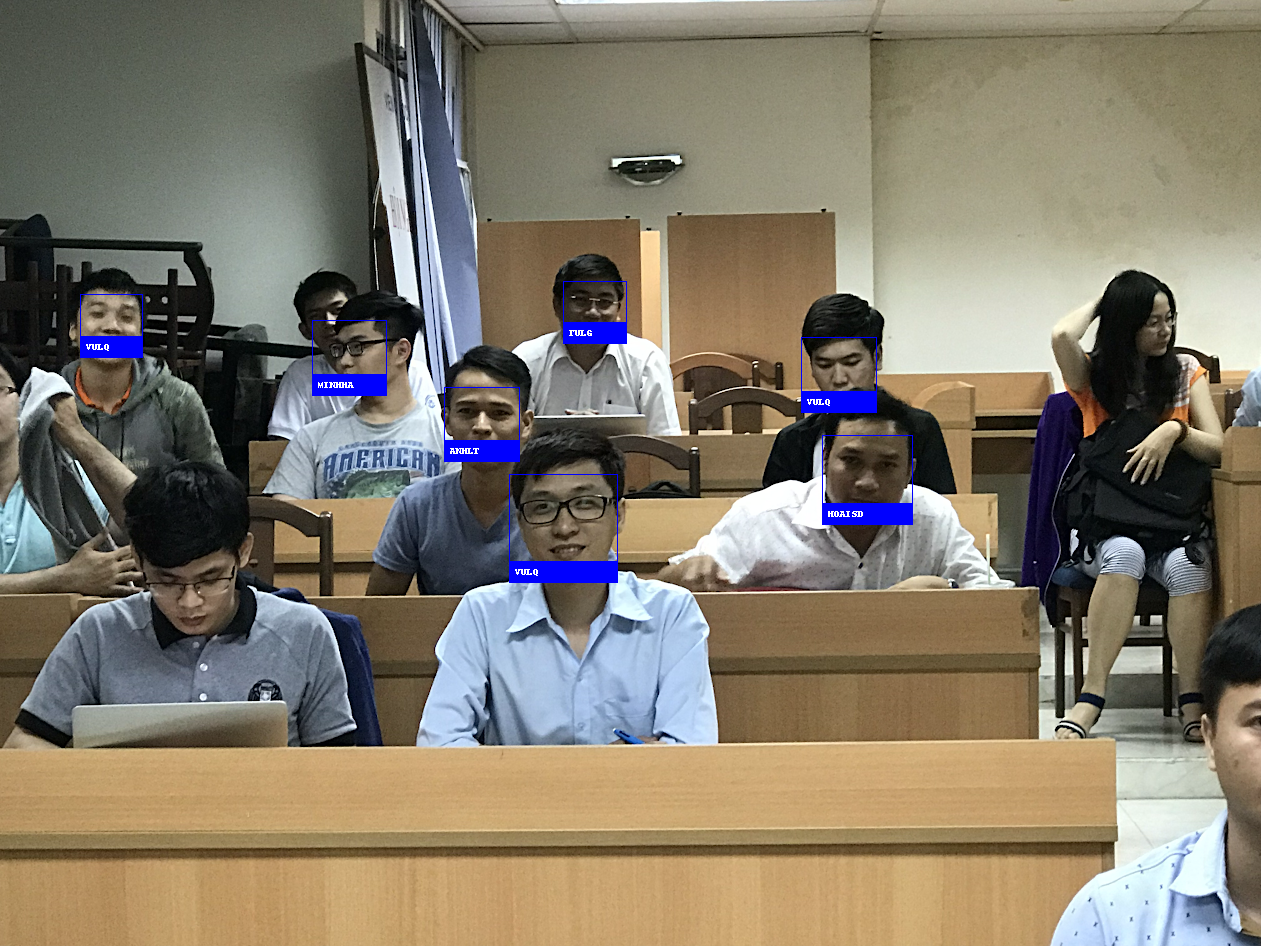

In [67]:
# STEP 2: Sử dụng knn đã train để nhận dạng mặt
for image_file in os.listdir("../test"):
    full_file_path = os.path.join("../test", image_file)

    print("Looking for faces in {}".format(image_file))

    # Tìm mặt tất cả mọi người trong ảnh sử dụng hàm predict ở trên
    predictions = predict(full_file_path, model_path="trained_knn_model.clf")

    # In kết quả vào console
    for name, (top, right, bottom, left) in predictions:
        print("- Found {} at ({}, {})".format(name, left, top))
    # Vẽ mặt vào ảnh
    show_prediction_labels_on_image(os.path.join("../test", image_file), predictions)

Phân tích kết quả test:
Ảnh 1.png:

Số mặt detect: 8/9

Số mặt recognition: 8/9

Số mặt mới unknown: 0/9

Số mặt regcognition đúng: 0/9

-> Vì để threshold quá cao nên mặt mới sẽ bị nhận diện nhầm, set lại threshold sẽ cho kết quả tốt hơn

Ảnh 2.png
Số mặt detect: 6/13

Số mặt recognition: 6/6

Số mặt mới unknown: 0/6

Số mặt regcognition đúng: 0/6

-> Threshold quá cao nên mặt unknown bị nhận diện nhầm, set lại threshold sẽ cho kết quả tốt hơn

Ảnh 3.png

Số mặt detect: 15/18

Số mặt recognition: 12/15

Số mặt mới unknown: 3/15

Số mặt regcognition đúng: 10/12

-> knn cho kết quả khá chính xác với threshold 0.6 cho các mặt đã có trong db

Ảnh 4.png

Số mặt detect: 7/10

Số mặt recognition: 7/7

Số mặt mới unknown: 0/7

Số mặt regcognition đúng: 4/7

-> knn cho kết quả khá thấp, nhận diện nhầm khá cao